## Introduction and References

In these notes we consider the range enclosure method using parallelotopes from [Goldsztejn and Ishii, 2016](http://goldsztejn.com/publications/RC2016.pdf); we will call that reference [GI16] in the rest of the notebook.
The method described in Section 3.2 of [GI16] proposes a way to obtain the enclosure of the image set of a parallelotope through a differentiable function, using interval arithmetic methods.

We will use the Julia library [LazySets.jl](https://github.com/JuliaReach/LazySets.jl/) to define and work with parallelotopes and other set representations; see the [documentation of LazySets](https://juliareach.github.io/LazySets.jl/dev/) for further details. We also use the [IntervalArithmetic.jl](https://github.com/JuliaIntervals/IntervalArithmetic.jl) for interval arithmetic computations. Apart from these libraries, we use [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) for differentiation of functions. Finally, we use [Plots.jl](http://docs.juliaplots.org/latest/) together with the [GR](https://github.com/jheinen/GR.jl) backend to produce some nice pictures!

It is planned to make available the method explored in this notebook in the package [RangeEnclosures.jl](https://github.com/JuliaReach/RangeEnclosures.jl), see issue [RangeEnclosures#22](https://github.com/JuliaReach/RangeEnclosures.jl/issues/22).

An application of this enclosure method for reachability computations has been referenced in issue [Reachability#636](https://github.com/JuliaReach/Reachability.jl/issues/636).

In [1]:
using Dates

now()

2019-12-27T07:02:23.056

## Parallelotopes

Simply put, a parallelotope is the image of a box under an affine map. More precisely, parallelotopes are centrally symmetric convex polytopes in $\mathbb{R}^n$ having
$2n$ pairwise parallel constraints. Every parallelotope is a particular case of a [zonotope](https://juliareach.github.io/LazySets.jl/dev/lib/representations/#Zonotope-1) whose order is one (recall that the *order* is the ratio between the number of generators and the ambient dimension).

Parallelotopes can be represented either in **constraint form** or in
**generator form**.
Depending on the use case, the constraint form or the generator may be preferable over the other. 

**Note.** At the time of writing, a set type specific to parallelotopes is not yet available in LazySets, although we are working on it in [LazySets#1632](https://github.com/JuliaReach/LazySets.jl/pull/1632). In that PR we introduce the `HParallelotope` which implements parallelotopes in constraint form. However as shown below, it is easy to work with parallelotopic sets using LazySets, either through an `AffineMap`, or just using a `Zonotope` (with the advantage that zonotopes already have lots of methods available).

In [GI16], they introduce the parallelotope as the tuple $\langle A, \mathbf{u}, \tilde{x}\rangle$ such that

$$
P = \langle A, \mathbf{u}, \tilde{x}\rangle = \{ x \in \mathbb{R}^n: x = \tilde{x} + Au,~~ u \in \mathbf{u}\},
$$
where $A \in \mathbb{R}^{n\times n}$ is a squre matrix, $\mathbf{u}$ is a hyperrectangular set, and $\tilde{x} \in \mathbb{R}^n$ is a vector. Here, by hyperrectangular set we mean a box-shaped set (but the length of each side is not necessarily the same).

To closely follow the notation in [GI16], let's define the above set using the lazy operation `AffineMap`, see the documentation of [lazy affine map](https://juliareach.github.io/LazySets.jl/dev/lib/operations/#LazySets.AffineMap) in LazySets for details.

In [2]:
using LazySets

In [3]:
Parallelotope(A, 𝐮, x̃) = x̃ ⊕ A*𝐮

Parallelotope (generic function with 1 method)

Here we used the Minkowski sum operator, $\oplus$, to define a [lazy translation](https://juliareach.github.io/LazySets.jl/dev/lib/operations/#LazySets.Translation) which combined with a lazy linear map automatically detects and creates a new affine map.
In other words, for LazySets the definition given above is equivalent to the command `AffineMap(A, 𝐮, x̃)`.

We now give an illustration of the new function `Parallelotope`.

**Note.** The symbol $\oplus$ is input in Julia with the command `\oplus[TAB]`. The black font is input with `\bfu[TAB]`. The tilde is written `x\tilde[TAB]`. For other unicode characteres in Julia, see [the Unicode Input documentation](https://docs.julialang.org/en/v1/manual/unicode-input/#Unicode-Input-1).

### Example

Consider, in dimension $n=2$, the parallelotope

$$
P = \left\{ x \in \mathbb{R}^2: x = \binom{0.5}{0.5} + \begin{pmatrix} 1 & 2 \\ 2 & 1 \end{pmatrix}u,~~ u \in B_\infty(1.0)\right\},
$$
where $B_\infty(r)$ denotes the [infinity-norm ball](https://en.wikipedia.org/wiki/Norm_(mathematics)#Maximum_norm_(special_case_of:_infinity_norm,_uniform_norm,_or_supremum_norm)) centered at the origin and with radius $r$. In LazySets, such ball can be defined with `BallInf(zeros(n), r)`, ie. the first argument is the (vector) center and the second argument is the (scalar) radius. Use the in-line help `?BallInf` for details and examples.

In [4]:
A = [1 2; 2 1.]
𝐮 = BallInf(zeros(2), 1.0)
x̃ = [0.5, 0.5];

In [5]:
P = Parallelotope(A, 𝐮, x̃)

AffineMap{Float64,BallInf{Float64},Float64,Array{Float64,2},Array{Float64,1}}([1.0 2.0; 2.0 1.0], BallInf{Float64}([0.0, 0.0], 1.0), [0.5, 0.5])

Note that `P` is of type `AffineMap`. We can easily plot the parallelotope using the function `plot`, which requires that we have loaded the library `Plots` beforehand.

In [6]:
using Plots

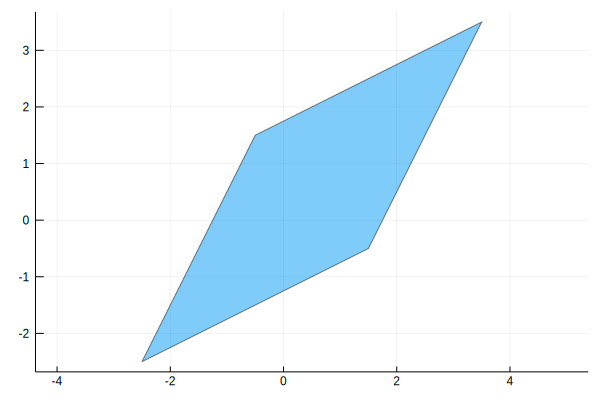

In [7]:
plot(P, ratio=1)

Following the notation [GI16], let's use $\square(\cdot)$ to denote the operator that returns a tight box approximation of the given set. In LazySets, this function is called [box_approximation](https://juliareach.github.io/LazySets.jl/dev/lib/approximations/#LazySets.Approximations.box_approximation).

In [8]:
# short-cut notation for the box approximation of a set
□(X) = box_approximation(X)

□ (generic function with 1 method)

In [9]:
Pbox = □(P)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.5, 0.5], [3.0, 3.0])

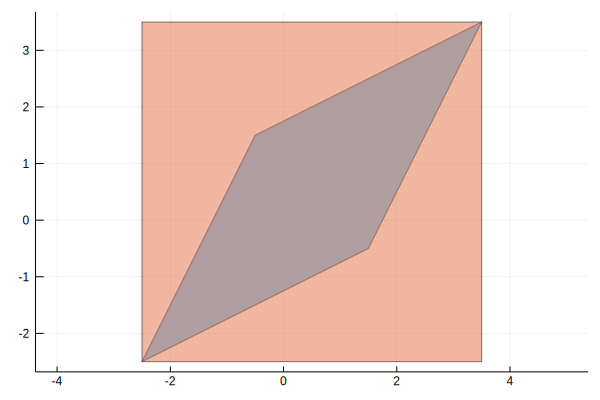

In [10]:
plot!(Pbox)

The figure confirms that the outer set is a tight box overapproximation of the parallelotope.

The set set 𝐮 can be more generally defined by lengths of different sizes using a `Hyperrectangle`. In this case, the radius is a vector instead of a scalar, as in the case of `BallInf`. Let's try using a hyperrectangle which is twice as big in the $x$-direction than the $y$-direction.

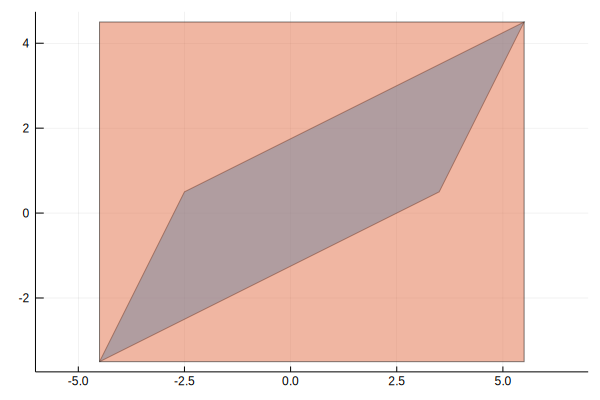

In [11]:
A = [1 2; 2 1.]
𝐮 = Hyperrectangle(zeros(2), [1.0, 2.0])
x̃ = [0.5, 0.5];

Q = Parallelotope(A, 𝐮, x̃)

plot(Q, ratio=1)

plot!(□(Q))

**Note.** The `Hyperrectangle` type is analogue to the [IntervalArithmetic.IntervalBox](https://juliaintervals.github.io/IntervalArithmetic.jl/latest/multidim/#Multi-dimensional-boxes-1) type, and it can be converted back and forth using the `convert` method defined in LazySets. The technical difference that `Hyperrectangle` stores the (vector) center and (vector) radius, while `IntervalBox` stores the one-dimensional intervals as an array.

To conclude this section, note that our set representation is not bound to be used in low dimensions. Below, we test inclusion between a randomly generated 100-dimensional parallelotope and its box approximation. The inclusion check is efficient and runs in a couple of `ms` or less. It works by using suitable choices of support function evaluations. Have in mind that `𝐮` in this example has $2^{100}$ vertices!

In [12]:
n = 100

@time begin
    A = rand(n, n)
    𝐮 = BallInf(zeros(n), 1.0)
    x̃ = rand(n)

    P = Parallelotope(A, 𝐮, x̃);
    BP = □(P);
    
    # inclusion check
    P ⊆ BP
end

  0.270175 seconds (207.74 k allocations: 11.050 MiB, 3.16% gc time)


true

## Range enclosures of functions and their derivatives

Several methods to compute the range enclosures of a function exist. The package [RangeEnclosures.jl](https://github.com/JuliaReach/RangeEnclosures.jl) aims at providing a unified interface for such different methods available in the Julia ecosystem. Computing interval enclosures of functions and their derivatives is required to implement Theorem 3.1 of [GI16].

In [13]:
using RangeEnclosures

As a "trivial" case, consider enclosing the range of the scalar field $f(x) = 2x$ and its derivative, the constant function $f'(x) = 2$.

In [14]:
f(x) = 2x

f (generic function with 1 method)

In [15]:
enclose(f, 1 .. 2)

[2, 4]

To enlose the derivative function we will use the package [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl), which uses forward-mode automatic differentiation.

In [16]:
using ForwardDiff

In [17]:
∂f(x) = ForwardDiff.derivative(f, x)

∂f (generic function with 1 method)

In [18]:
enclose(∂f, 1 .. 2)

[2, 2]

In these cases, the range enclosure is tight. However, in general there is an overapproximation error. Different methods can yield different approximation errors; see the documentation of [RangeEnclosures.jl](https://github.com/JuliaReach/RangeEnclosures.jl) for additional examples.

Next we consider our running example, a Lotka-Volterra system in discrete time.

### Running example

Consider the two-dimensional example given below. This is a Lotka-Volterra system similar to the one used in Section 5.2.7 of [GI16].

In [19]:
ω(x) = [0.2*x[1] - 0.04*x[1]*x[2], -0.1*x[1] + 0.2*x[1]*x[2]]

ω (generic function with 1 method)

In [20]:
∂ω(x) = ForwardDiff.jacobian(ω, x)

∂ω (generic function with 1 method)

For each $x \in \mathbb{R}^2$, `∂ω(x)` returns the $2\times 2$ matrix of partial derivatives of first order, evaluated at $x$.

In [21]:
∂ω([1.0, 2.0])

2×2 Array{Float64,2}:
 0.12  -0.04
 0.3    0.2 

For our example, let's evaluate the range of $\omega$ and the field defined by its first derivative, $\partial \omega$, over the box $b$ that is defined by the box overapproximation of our domain parallelotope $P$.

In [22]:
A = [1 2; 2 1.]
𝐮 = BallInf(zeros(2), 1.0)
x̃ = [0.5, 0.5];
P = Parallelotope(A, 𝐮, x̃)
Pbox = □(P)

using IntervalArithmetic: IntervalBox

b = convert(IntervalBox, Pbox)

[-2.5, 3.5] × [-2.5, 3.5]

In [23]:
# define coordinate functions
ω₁(x, y) = ω([x, y])[1]
ω₂(x, y) = ω([x, y])[2]

∂ω₁₁(x, y) = ∂ω([x, y])[1, 1]
∂ω₁₂(x, y) = ∂ω([x, y])[1, 2]
∂ω₂₁(x, y) = ∂ω([x, y])[2, 1]
∂ω₂₂(x, y) = ∂ω([x, y])[2, 2]

∂ω₂₂ (generic function with 1 method)

We can obtain bounds on each coordinate function using IntervalArithmetic:

In [24]:
@show bound_ω₁ = enclose(ω₁, b)
@show bound_ω₂ = enclose(ω₂, b)

bound_ω_IA = bound_ω₁ × bound_ω₂

bound_ω₁ = enclose(ω₁, b) = [-0.990001, 1.05001]
bound_ω₂ = enclose(ω₂, b) = [-2.10001, 2.70001]


[-0.990001, 1.05001] × [-2.10001, 2.70001]

Now let's obtain bounds on the partial derivatives of each coordinate function:

In [25]:
@show bound_∂ω₁₁ = enclose(∂ω₁₁, b)
@show bound_∂ω₁₂ = enclose(∂ω₁₂, b)
@show bound_∂ω₂₁ = enclose(∂ω₂₁, b)
@show bound_∂ω₂₂ = enclose(∂ω₂₂, b);

bound_∂ω₁₁ = enclose(∂ω₁₁, b) = [0.0599999, 0.300001]
bound_∂ω₁₂ = enclose(∂ω₁₂, b) = [-0.140001, 0.100001]
bound_∂ω₂₁ = enclose(∂ω₂₁, b) = [-0.600001, 0.600001]
bound_∂ω₂₂ = enclose(∂ω₂₂, b) = [-0.500001, 0.700001]


Let's graphically evaluate the quality of the range enclosures by random sampling the domain $b$ with LazySets. The command `sample` requires the optional package [Distributions.jl](https://github.com/JuliaStats/Distributions.jl).

In [26]:
using Distributions
using LazySets: sample

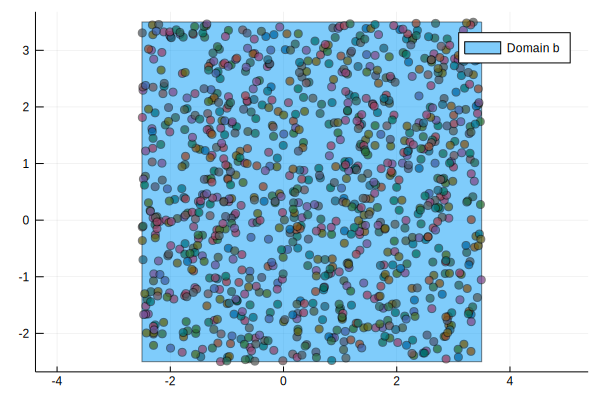

In [27]:
bh = convert(Hyperrectangle, b)
nsamples = 1_000
S = sample(bh, nsamples)

# plot the domain and the points used to sample the range of ω
plot(bh, lab="Domain b", ratio=1)
plot!([Singleton(s) for s in S])

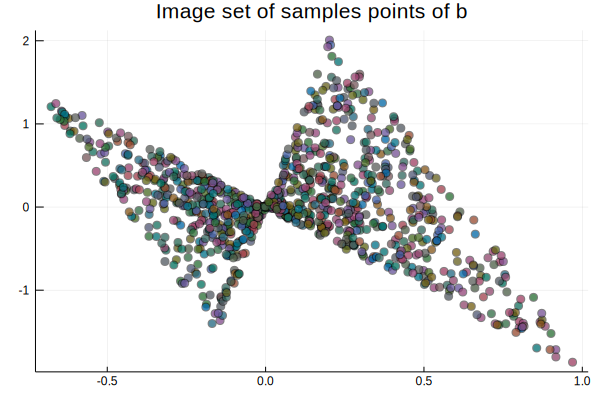

In [28]:
ωsampled = ω.(S)
plot([Singleton(s) for s in ωsampled], title="Image set of samples points of b")

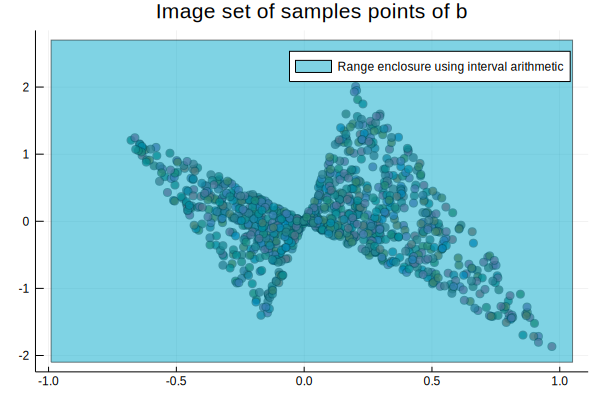

In [29]:
plot!(bound_ω_IA, lab="Range enclosure using interval arithmetic")

As a point of comparison using other enclosure method, let's evaluate using [TaylorModels.jl](https://github.com/JuliaIntervals/TaylorModels.jl).

bound_ω₁ = enclose(ω₁, b, :TaylorModels) = [-0.870001, 1.05001]
bound_ω₂ = enclose(ω₂, b, :TaylorModels) = [-2.10001, 2.10001]


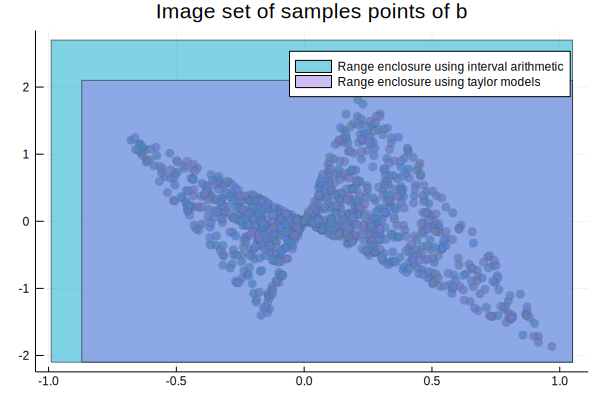

In [31]:
@show bound_ω₁ = enclose(ω₁, b, :TaylorModels)
@show bound_ω₂ = enclose(ω₂, b, :TaylorModels)

bound_ω_IA = bound_ω₁ × bound_ω₂

plot!(bound_ω_IA, lab="Range enclosure using taylor models")

We can verify graphically that the overapproximation obtained with `TaylorModels` is better than the one obtained with the simpler (but faster) range approximation using IntervalArithmetic. Moreover, further testing shows that other methods such as [IntervalOptimisation.jl](https://github.com/JuliaIntervals/IntervalOptimisation.jl) (also available as `:IntervalOptimisation`) give bounds which are sometimes tighter, but depends on the domain.

We could similarly work with the bounds computed for `∂ω`, or refine these bounds using other methods.

## Implementation of Theorem 3.1 from [GI16]

### Preconditions

The algorithm requires that $0 \in 𝐮$. This is the case in our running example.

In [32]:
@assert zeros(2) ∈ 𝐮

### Choosing the center

I think there is a typo in the statement of the theorem, as explained in [this comment](https://github.com/JuliaReach/Reachability.jl/issues/636#issuecomment-569215340).

Let us continue by assuming that the statement should be `y:= 𝛚(□⟨𝐱⟩)`.

In [33]:
𝐲 = bound_ω_IA

[-0.870001, 1.05001] × [-2.10001, 2.10001]

We choose `ỹ` as in Eq. (9), but assuming there is a typo and it should read `ỹ:= mid 𝛚(□⟨𝐱⟩)`.

In [34]:
ỹ = mid(bound_ω_IA)

2-element StaticArrays.SArray{Tuple{2},Float64,1,2} with indices SOneTo(2):
 0.09000000000000008
 0.0                

### Choosing the shape matrix

We need the interval matrix 𝐉 that contains the range enclosure of the derivatives of ω, `𝐉 := ∂𝛚(□⟨𝐱⟩)`.

Here we will use `IntervalOptimisation`.

In [35]:
bound_∂ω₁₁ = enclose(∂ω₁₁, b, :IntervalOptimisation)
bound_∂ω₁₂ = enclose(∂ω₁₂, b, :IntervalOptimisation)
bound_∂ω₂₁ = enclose(∂ω₂₁, b, :IntervalOptimisation)
bound_∂ω₂₂ = enclose(∂ω₂₂, b, :IntervalOptimisation)

𝐉 = [bound_∂ω₁₁ bound_∂ω₁₂; bound_∂ω₂₁ bound_∂ω₂₂]

2×2 Array{IntervalArithmetic.Interval{Float64},2}:
  [0.0599999, 0.300001]  [-0.140001, 0.100001]
 [-0.600001, 0.600001]   [-0.500001, 0.700001]

An heuristic for choosing the matrix `B` is given in Eq. (10) of [GI16]). First we compute `(mid 𝐉) * A` and compute its condition number using `LinearAlgebra.cond`.

In [36]:
mJ = mid.(𝐉)

2×2 Array{Float64,2}:
  0.18         -0.02
 -5.55112e-17   0.1 

In [37]:
mJ * A

2×2 Array{Float64,2}:
 0.14  0.34
 0.2   0.1 

In [38]:
using LinearAlgebra: cond

cond(mJ * A)

3.107865369930589

Sicne `(mid 𝐉) * A` is well-conditioned, we just let `B = (mid 𝐉) * A`.

In [39]:
B = mid.(𝐉) * A

2×2 Array{Float64,2}:
 0.14  0.34
 0.2   0.1 

**Note.** If `(mid 𝐉) * A` had been ill-conditioned, we would have needed to orthogonalize the matrix using the QR decomposition available in Julia, see the documentation page [Matrix factorizations](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#man-linalg-factorizations-1) for details.

### Computing the box 𝐯

In [GI16], it is proposed to obtain the interval matrix inverse by using a result that appears in [A. Neumaier. Interval Methods for Systems of Equations. Cambridge Univ. Press,
1990.]. We plan to add this method in [IntervalMatrices#39]( https://github.com/JuliaReach/IntervalMatrices.jl/issues/59). To simplify the presentation here we just compute the matrix inverse in Julia.

In [40]:
invB = inv(B)

2×2 Array{Float64,2}:
 -1.85185   6.2963 
  3.7037   -2.59259

The box `𝐯` is computed according to the formula

$$
𝐯 = B^{-1} (𝐲 - ỹ) + (B^{-1} 𝐉 A) 𝐮  := H + Z
$$

The result should be a hyperrectangular set. Let's consider these terms separately.

The first term first translates `𝐲`, then multiplies by the interval matrix (a usual matrix in our case) $B^{-1}$.

In [41]:
H = invB * (𝐲 - ỹ)

[-15.0001, 15.0001] × [-9.00001, 9.00001]

In [42]:
typeof(H)

IntervalBox{2,Float64}

The second term is trickier: the result of `(B^{-1} 𝐉 A)` is an interval matrix, which applied to the box `𝐮` does not longer give a box. We could compute an outer box approximation of `(B^{-1} 𝐉 A)𝐮`, but we can get a better approximation by taking the zonotopic overapproximation of the interval matrix map, as presented in   [Althoff, Stursberg, Buss. Reachability analysis of linear systems with
uncertain parameters and inputs. CDC 2007]. That method is implemented in LazySets if the optional dependency `IntervalMatrices` has been loaded.

In [43]:
M = invB * 𝐉 * A

2×2 Array{IntervalArithmetic.Interval{Float64},2}:
 [-11.0001, 13.0001]   [-12.0001, 12.0001] 
  [-6.00001, 6.00001]   [-5.00001, 7.00001]

In [44]:
using IntervalMatrices

In [45]:
L = IntervalMatrix(M) * 𝐮

LinearMap{Float64,BallInf{Float64},IntervalArithmetic.Interval{Float64},IntervalMatrix{Float64,IntervalArithmetic.Interval{Float64},Array{IntervalArithmetic.Interval{Float64},2}}}(IntervalArithmetic.Interval{Float64}[[-11.0001, 13.0001] [-12.0001, 12.0001]; [-6.00001, 6.00001] [-5.00001, 7.00001]], BallInf{Float64}([0.0, 0.0], 1.0))

In [46]:
Z = overapproximate(L, Zonotope)

Zonotope{Float64}([0.0, 0.0], [1.0 0.0 24.000000000000014 0.0; 0.0 1.0 0.0 12.000000000000007])

In [47]:
H = convert(Hyperrectangle, H)
𝐯 = □(H ⊕ Z)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [40.00000000000002, 22.000000000000014])

In [48]:
ỹ = Vector(ỹ)
Q = Parallelotope(B, 𝐯, ỹ)

AffineMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2},Array{Float64,1}}([0.14 0.34; 0.1999999999999999 0.09999999999999987], Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0], [40.00000000000002, 22.000000000000014]), [0.09000000000000008, 0.0])

**Note.** The `ỹ = Vector(ỹ)` command should not be needed but it is a current limitation that I found writing this notebook, and it has been reported in [LazySets#1874](https://github.com/JuliaReach/LazySets.jl/issues/1874).

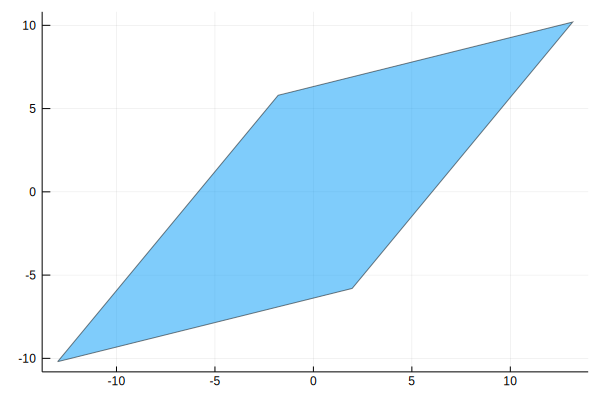

In [49]:
plot(Q)

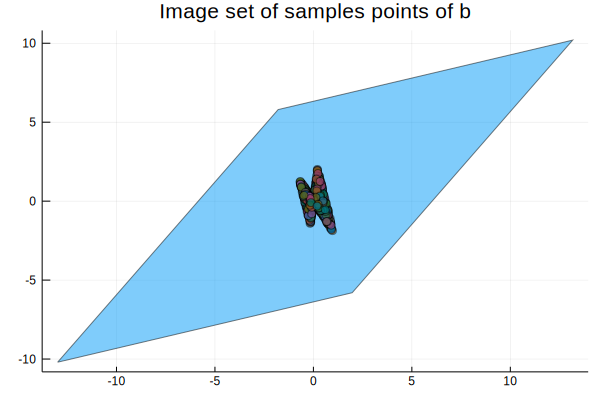

In [50]:
plot!([Singleton(s) for s in ωsampled], title="Image set of samples points of b")

The computed approximation is too bad.. why?

## Complete code [WIP]

The complete code from this notebook, together with some additional argument checks that were omitted to simplify the presentation, is included below.

In [ ]:
"""
    Parallelotope(A, 𝐮, x̃)

Return the parallelotope in generator representation described by the given tuple.

### Input

- `A` -- generator matrix
- `𝐮` -- hyperrectangular set
- `x̃` -- center (vector) 

### Output

The lazy affine map ``x̃ ⊕ A𝐮``.
"""
function Parallelotope(A, 𝐮, x̃)
    n = checksquare(A)
    if !(zeros(n) ∈ 𝐮)
        throw(ArgumentError("the interval vector 𝐮 should contain the origin"))
    end
    return AffineMap(A, 𝐮, x̃)
end